<a href="https://colab.research.google.com/github/skc46/ML_hackathon_2021/blob/main/ParticleImagesChallenge/ParticleImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon - Particle Images
## Problem Statement 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 



## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/content/Particle_Images


In [3]:
mkdir data/

# Download the Dataset

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2021-11-19 04:22:49--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.28, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  18.6MB/s    in 5.6s    

Last-modified header invalid -- time-stamp ignored.
2021-11-19 04:22:56 (14.8 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2021-11-19 04:22:56--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 137.138.120.151, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391

In [5]:
pip install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2


# Import modules

In [6]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adamax
from tensorflow.keras.initializers import TruncatedNormal, glorot_normal
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalAvgPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import roc_curve, auc, accuracy_score

import matplotlib.pyplot as plt

# Keras Model Parameters

In [15]:
#lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 32     # Training batch size
train_size  = 60000     # Training size
valid_size  = 2000     # Validation size
test_size   = 20000     # Test size
epochs      = 25       # Number of epochs
doGPU       = True    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [8]:
if doGPU:
    import tensorflow.compat.v1 as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [9]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [16]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = train_size, train_size+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = (train_size+valid_size), (train_size+valid_size)+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

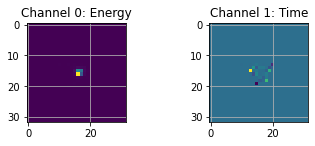

0.6846605


In [28]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()
print(np.max(X_train[111,:,:,0]))

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [27]:
### Define Convolutional Neural Network (CNN) Model ###
tensorflow.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=2, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(Conv2D(16, activation='relu', kernel_size=2, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, activation='relu', kernel_size=5, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Conv2D(64, activation='relu', kernel_size=5, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1.e-6)

In [28]:
history=model.fit(X_train, y_train,\
        epochs=25,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr], \
        verbose=1)

Epoch 1/25
3750/3750 [==============================] - 25s 6ms/step - loss: 0.6348 - accuracy: 0.6400 - val_loss: 0.7022 - val_accuracy: 0.5305 - lr: 0.0010
Epoch 2/25
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5916 - accuracy: 0.6969 - val_loss: 0.7131 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 3/25
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5811 - accuracy: 0.7066 - val_loss: 0.5800 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 4/25
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5743 - accuracy: 0.7120 - val_loss: 0.6288 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 5/25
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5717 - accuracy: 0.7132 - val_loss: 0.5840 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 6/25
3750/3750 [==============================] - 23s 6ms/step - loss: 0.5672 - accuracy: 0.7172 - val_loss: 0.7818 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 7/25
3750/3750 [==============================

## Train the Model
### You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

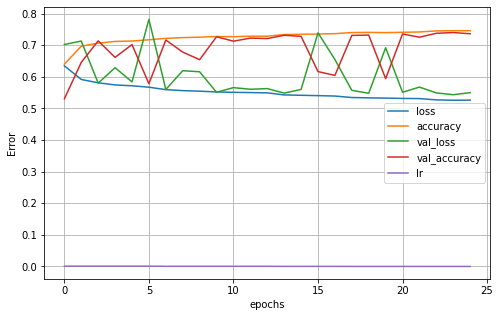

In [29]:

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel('Error')
plt.show()

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [30]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

125/125 [==============================] - 0s 3ms/step - loss: 0.5500 - accuracy: 0.7362

Validation loss / accuracy: 0.5500 / 0.7362
Validation ROC AUC: 0.7971466250000001
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5481 - accuracy: 0.7311

Test loss / accuracy: 0.5481 / 0.7311
Test ROC AUC: 0.79998152


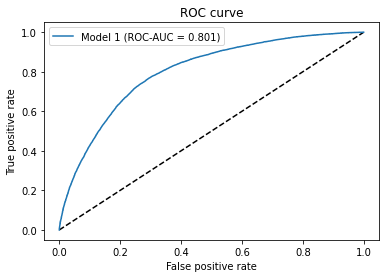

In [18]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#ResNet




In [37]:
from functools import partial
#Let's create a ResidualUnit layer
import tensorflow as tf
import keras
DefaultConv2D = partial(Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(tensorflow.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tensorflow.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Creating 2 convoluation layers each with 16 filters (kernel_size=3) followed by a Max pooling layer. After the pooling layer 4 residual layers, with different filter sizes (16, 32, and 64) are added. The residual block is followed by the Max pooling layer. Then 3 dense layers are added and an output dense layer with one neuron.

In [46]:
tensorflow.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(DefaultConv2D(16, kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [16] * 1 + [32] * 2 + [64] * 1:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(MaxPooling2D(pool_size=3, strides=1, padding="SAME"))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))


In [47]:
model.compile(loss='binary_crossentropy', optimizer=Nadam(lr=0.001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1.e-6)
#learning_schedule = 
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

In [49]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

1563/1563 [==============================] - 8s 5ms/step - loss: 0.5342 - accuracy: 0.7365

Validation loss / accuracy: 0.5342 / 0.7365
Validation ROC AUC: 0.8078685704
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5289 - accuracy: 0.7421

Test loss / accuracy: 0.5289 / 0.7421
Test ROC AUC: 0.8124762184000001


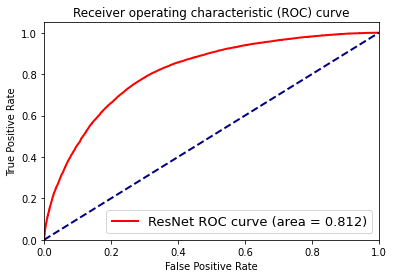

In [50]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ResNet ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Submission format: 
### Please submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). You are free to choose Machine Learning Framework of your choice. 